## Author Explorer: Let's Make Some Paper Lists!

Let's try to produce a list of interesting AI papers from some important figures in the field.

### Step 1: Examine Input Data

To do so we'll use some data that's not yet available via Semantic Scholar's public API (we're working on that). Let's take a look at the authors we have in that output:

In [36]:
import json
import pandas as pd

from IPython.display import HTML, display
from pretty_html_table import build_table

def s2_url(path: str) -> str:
    url = f"https://semanticscholar.org{path}"
    return url

def href(url: str) -> str:
    return f"<a href={url}>{url}</a>"

author_citations = json.load(open("author_citations.json", "r"))

authors = []
for id, a in author_citations.items():
    authors.append({ "id": id, "name": a["name"], "url": href(s2_url(f"/author/{id}")) })
    
adf = pd.DataFrame(authors)
display(HTML(build_table(adf, 'green_dark', escape=False)))


id,name,url
1780531,Dan Weld,https://semanticscholar.org/author/1780531
2684226,Ani Kembhavi,https://semanticscholar.org/author/2684226
1699545,Yejin Choi,https://semanticscholar.org/author/1699545
48323507,Peter Clark,https://semanticscholar.org/author/48323507
144365875,Noah Smith,https://semanticscholar.org/author/144365875
2548384,Hannaneh Hajishirzi,https://semanticscholar.org/author/2548384
1701686,Ilya Sutskever,https://semanticscholar.org/author/1701686
1695689,Geoffrey E. Hinton,https://semanticscholar.org/author/1695689
1741101,Oren Etzioni,https://semanticscholar.org/author/1741101
48004138,Li Fei-Fei,https://semanticscholar.org/author/48004138


This looks like a good set of authors to start with. Maybe we'll add more in the future, if there's interest.

Before we move on. Let's talk quickly about the data that's in `author_citations.json`. That file contains a map of author IDs to the top 25 papers they cite the most, per our database. The papers are sorted by unique citations -- which means if a paper is cited twice in a single document, it's only counted once. That helps control for scenarios where the "importance" of the paper might be inflated by the number of citations in the document. We could go on about this for awhile, and have been a lot of thought into things like classifying the importance of citations. More on that another time :).

The file could thus be described by the type `map[str, AuthorCitations]`, where each `AuthorCitations` instance is defined as such:

```
class AuthorCitations:
    # The author's anme
    name: str
    # The 25 most cited papers by that author.
    papers: list[CitedPaper]
```

...and a `CitedPaper` looks like so:

```
class CitedPaper:
    # A SHA derived from the paper, that acts as a public, unique identifier. We could talk a lot about
    # how this is generated but won't here.
    paper_sha: str
    # An internal identifier for the paper. You can ignore this.
    corpus_paper_id: int
    # The paper's title.
    title: str
    # The unique number of times the paper was cited by the author.
    n_citations: int
    # The total number of times the paper was cited across the whole corpus, or the "global citations".
    g_citations: int
    # The year the paper was published
    year: int
    # True if the cited paper was also written by the author
    self_cited: bool
```

Let's dump out some data to confirm the shape:
   




In [37]:
from copy import deepcopy

first_id = list(author_citations.keys())[0]

# Make a copy, to not mutate the original
first_author = deepcopy(author_citations[first_id])
first_author["papers"] = first_author["papers"][0:2]

print(json.dumps({ first_id: first_author }, indent=2))

{
  "1780531": {
    "name": "Dan Weld",
    "papers": [
      {
        "paper_sha": "6e1bd5758be5495141d56de31c28d57f55c56f3e",
        "corpus_paper_id": 5329862,
        "title": "UCPOP: A Sound, Complete, Partial Order Planner for ADL",
        "n_citations": 33,
        "g_citations": 930,
        "year": 1992,
        "self_cited": true
      },
      {
        "paper_sha": "02cc8ee37b11e7bd96a3bc1095a8bee6b154bcf4",
        "corpus_paper_id": 2584923,
        "title": "Systematic Nonlinear Planning",
        "n_citations": 29,
        "g_citations": 731,
        "year": 1991,
        "self_cited": false
      }
    ]
  }
}


### Step 2: Enrich the Data using Semantic Scholar's Public API

Next we'll go through the papers they cite the most and mix in some extra information from Semantic Scholar's API that we'll use later.

We sort each author's list of citations by the `n_citations` field. This is the number of unique papers by the author that cited the paper.

In [38]:
from typing import Optional, List, Tuple
from tqdm import tqdm
from os import path

import requests

# To avoid rate limits, create a file called key.txt with your Semantic Scholar API key 
# as the contents.
api_key = None
if path.isfile("key.txt"):
    api_key = open("key.txt").read().strip()
if api_key is not None:
    assert(api_key != "")
    print("INFO: your Semantic Scholar API key will be used.")

def get_extra_fields(sha: str) -> Tuple[str, List[float]]:
    """
    Fetch the TLDR and SPECTRE embedding. These might not exist, so we handle
    failure gracefully.
    
    The first value is the TLDR. The second is the SPECTRE embedding.
    """    
    headers = None
    if api_key is not None:
        headers = { "x-api-key": api_key }
    resp = requests.get(
        f"https://api.semanticscholar.org/graph/v1/paper/{sha}?fields=tldr,embedding",
        headers=headers,
    )
    if resp.status_code != 200:
        return ["", []]
    payload = resp.json()
    tldr = payload.get("tldr")
    embed = payload.get("embedding")
    return (
        tldr["text"] if tldr is not None else "",
        embed["vector"] if embed is not None else []
    )

# We'll keep them in a list to use later
papers = []

for id, a in tqdm(author_citations.items()):
    most_cited = sorted(a["papers"], key=lambda p : p["n_citations"], reverse=True)    
    for p in most_cited[:10]:
        tldr, embed = get_extra_fields(p["paper_sha"])
        paper = {
            "id": id,
            "sha": p["paper_sha"],
            "names": [a["name"]], 
            "author_id": id,
            "title": p["title"],
            "n_citations": p["n_citations"],
            "g_citations": p["g_citations"],
            "self_citation": p["self_cited"],
            "year": p["year"],
            "url": s2_url(f"/paper/{p['paper_sha']}"),
            "tldr": tldr,
            "embedding": embed,
        }
        papers.append(paper)        
        
# We don't output much, so that this cell can be cached (it's slow).
print(len(papers))


INFO: your Semantic Scholar API key will be used.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]

160


160 papers are too many to display in a notebook. Clearly we need to build this into S2 instead :)

In the meantime we'll take a look at single author's list, just to see what things look like. Given this whole exercise spawned via curiosity about Ilya Sutskever's list, let's take a look at that list first.

In [39]:
def paper_meta_html(p) -> str:
    return f"""
        <p style="margin: 5px 0;">
            {p["year"]} • Unique Citations: {p["n_citations"]} • {"Self Citation" if p["self_citation"] else "Not Self Citation"}
        </p>
    """

def paper_html(p, meta) -> str:
    return f"""
        <div style="margin: 15px 0;">
            <h4 style="margin: 0; font-weight: bold; font-size: 16px">{p["title"]}</h4>
            {meta(p)}
            <div style="max-width: 70ch; margin: 5px 0;">
                <span style="font-size: 12px; background: #eee; border-radius: 2px; padding: 2px 4px; line-height: 1; display: inline-block">
                    TLDR
                </span>
                <span style="font-size: 12px;">{p["tldr"]}</span>
            </div>
            <div style="font-size: 12px">
                <a href="{p["url"]}">
                    {p["url"]}
                </a>
            </div>
        </div>
    """

ilyas = [ p for p in papers if p["author_id"] == "1701686" ]
ilyas_html = "\n".join([ paper_html(p, paper_meta_html) for p in ilyas ])
display(HTML(f"<div style='padding: 15px 0;'>{ilyas_html}</div>"))


Alright, we've got a starting point. There's clearly some important work here. But it's also pretty hard to assess how good this is or isn't. And as we mentioned before, we don't think any single author's list of citations could capture the diversity of the AI field (nor of most fields, for that matter). So let's do a bit more work.

### Step 3: Find the Intersection

What's more interesting than any author's list in isolation is the list of papers that they all cite. To do so we can go through the top 10 most cited papers per author and find those that they all cite. We'll rank the results by the unique number of authors (in our data) who cited them, preferring papers that were cited by more distinct individuals.



In [40]:
def common_paper_meta_html(p) -> str:
    cited_by = []
    for a in p["cited_by"]:
        cited_by.append(f"{a['name']} ({a['n_citations']})")
    cited_by_list = ", ".join(cited_by)
    return f"""
        <div style="margin: 5px 0;">
            {p["year"]}
        </div>
        <div style="margin: 5px 0;">
            <em>Cited By: {cited_by_list}</em>
        </div>        
    """

common = []
for sha, group in pd.DataFrame(papers).groupby("sha"):
    if len(group) == 1:
        continue
    by_name = {}
    paper = None
    for _, p in group.iterrows():
        paper = p
        for n in p["names"]:
            if n not in by_name:
                by_name[n] = { "name": n, "n_citations": 0 }
            by_name[n]["n_citations"] += p["n_citations"]
    cited_by = sorted(by_name.values(), key=lambda a: a["n_citations"], reverse=True)
    paper["cited_by"] = cited_by
    common.append(paper)    
    
common.sort(key=lambda p : len(p["cited_by"]), reverse=True)
list_html = "\n".join([ paper_html(p, common_paper_meta_html) for p in common ])
display(HTML(f"<div style='padding: 15px 0;'>{list_html}</div>"))

This list looks more interesting to us. There's a lot of really important work captured there. Just look at all of the folks citing the "Adam" paper -- and from a set of authors with different specialties. Neat!

It'd be interesting next to assess how many of these were cited by Ilya, as a proxy for how comprehensive his list is. Let's figure that out:


In [41]:
total = len(common)

author_names = set()
for p in common:
    for n in p["names"]:
        author_names.add(n)

overlap = []
for a in list(author_names):
    count = len([p for p in common if a in p["names"]])
    overlap.append({ "name": a, "count": count, "percent": f"{count/total:.0%}" })
    
overlap.sort(key=lambda o : o["count"], reverse=True)

display(HTML(build_table(pd.DataFrame(overlap), 'blue_dark', escape=False)))


name,count,percent
Hannaneh Hajishirzi,5,21%
R. Socher,4,17%
Yoshua Bengio,3,12%
Yann LeCun,3,12%
Oren Etzioni,3,12%
Geoffrey E. Hinton,2,8%
Li Fei-Fei,1,4%
Ian J. Goodfellow,1,4%
Noah Smith,1,4%
A. Karpathy,1,4%


Interesting. This does suggest Ilya's most cited papers overlap a fair amount with the other researchers in our list. Though the list in isolation also misses a lot. Clearly we're all better, together. Go open science :)

### Step 4: Similarity Analysis

We thought it'd be fun to go a step further and use the [SPECTER embeddings](https://github.com/allenai/specter) to visualize the lists of each of these offers. That'd give us some idea of how "similar" the things are that they're citing.

Let's do that next.

In [42]:
from sklearn.manifold import TSNE

import plotly.express as px
import numpy as np

In [43]:
unique_papers = dict()
for p in tqdm(papers):
    if p["sha"] not in unique_papers:
        unique_papers[p["sha"]]=p
    else:
        unique_papers[p["sha"]]["names"]+=p["names"]

author_paper_idx = dict()
for i, p in tqdm(enumerate(unique_papers)):
    for aname in unique_papers[p]["names"]:
        if aname not in author_paper_idx:
            author_paper_idx[aname] = []
        author_paper_idx[aname].append((unique_papers[p]["sha"], i))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 376804.40it/s]
110it [00:00, 448806.85it/s]


In [44]:
unique_paper_embs = np.array([unique_papers[p]["embedding"] for p in unique_papers])

reduced_embs = TSNE(
    n_components=2,
    perplexity=10,
    init="pca",
    n_iter=400,
    early_exaggeration=20,
    random_state=0,
).fit_transform(unique_paper_embs)

In [45]:
reduced_comps = []
for aname, ids in author_paper_idx.items():
    for idx in ids:
        reduced_comps.append({"Dim 1": reduced_embs[idx[1]][0], "Dim 2": reduced_embs[idx[1]][1], 
                              "Title": unique_papers[idx[0]]["title"], "Citations": unique_papers[idx[0]]["n_citations"],
                              "Cited By": aname})
reduced_df = pd.DataFrame(reduced_comps)

In [68]:
#static plot 
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 600

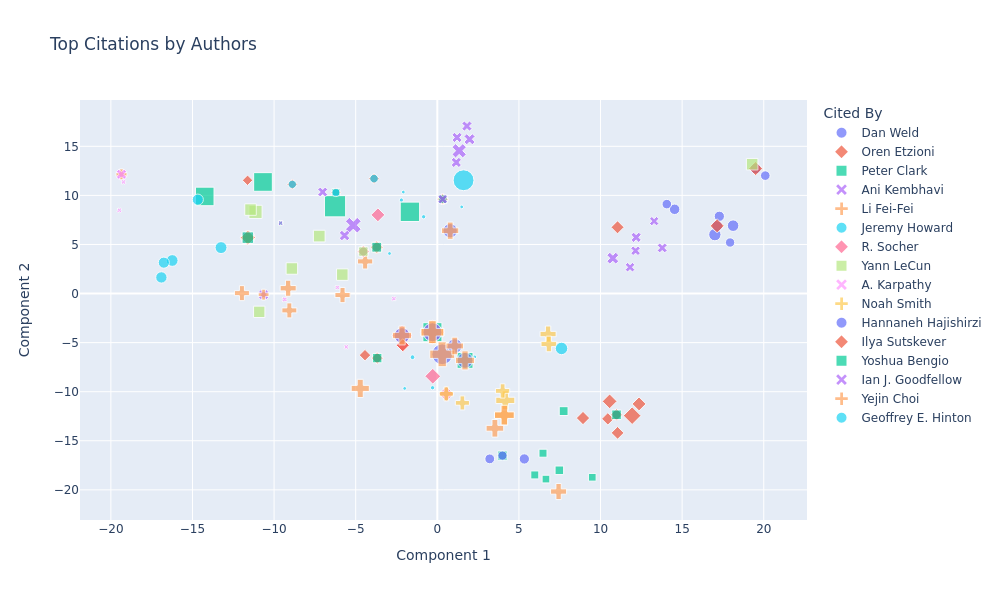

In [69]:
fig=px.scatter(reduced_df, x="Dim 1", y="Dim 2", color="Cited By", symbol="Cited By", title="Top Citations by Authors",
               hover_data=["Title"], size="Citations", size_max=15)
fig.show("png")
fig.show()

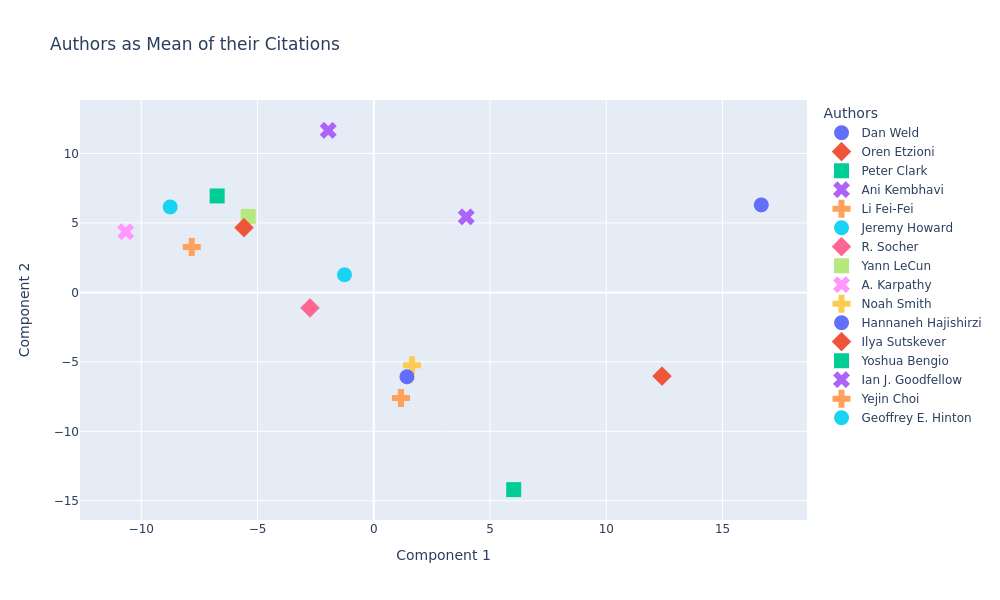

In [70]:
mean_reduced_embs = []
authors = list(author_paper_idx.keys())
for aname in authors:
    x=reduced_df[reduced_df["Cited By"]==aname]["Component 1"].mean()
    y=reduced_df[reduced_df["Cited By"]==aname]["Component 2"].mean()
    mean_reduced_embs.append((x,y))
    
fig=px.scatter(x=[c[0] for c in mean_reduced_embs], y=[c[1] for c in mean_reduced_embs], 
               labels= {"x": "Dim 1", "y": "Component 2", "color": "Authors", "symbol": "Authors"},
               color=authors, symbol=authors, title="Authors as Mean of their Citations",)
fig.update_traces(marker={'size': 15})
fig.show("png")
fig.show()

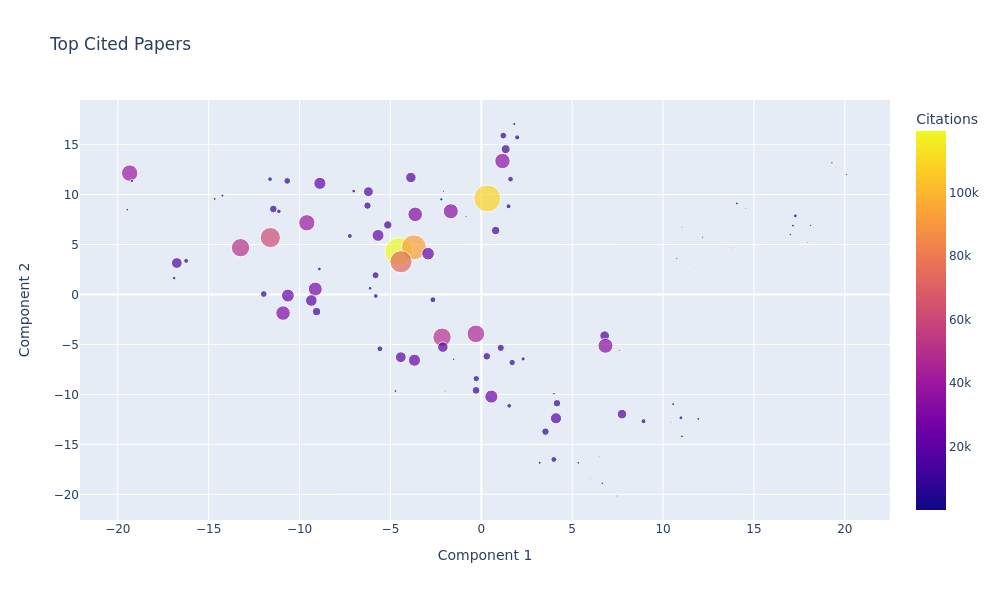

In [71]:
cited_papers_df = pd.DataFrame([{"Title": unique_papers[p]["title"], "Year": unique_papers[p]["year"], 
                                 "Citations": unique_papers[p]["g_citations"], 
                                 "Component 1": reduced_embs[i, 0], "Component 2": reduced_embs[i, 1]} 
                                for i, p in enumerate(unique_papers)])

fig=px.scatter(cited_papers_df, x="Component 1", y="Component 2", color="Citations", title="Top Cited Papers",
               hover_data=["Title", "Year"], size="Citations")
fig.show("png")
fig.show()

Interesting. There's clearly some clustering going on. There's also some outliers, and a few authors who appear to appear to be citing things that are a bit different more often.

We'd need to dig into this more to start drawing conclusions. But it's fun to think about never the less -- and maybe we'll inspire someone else to. Let us know if you dig in and discover any interesting patterns!


### That's all (for now)!

This was fun. We hope you enjoyed it too. We also think the list of papers probably includes a few that are worth reading if you're looking to learn more about AI. 

If you find this type of thing interesting, definitely look into [Semantic Scholar's Academic Graph API](https://www.semanticscholar.org/product/api). We're investing heavily in that direction, and hope to enable all sorts of interesting things like this.

We're also [hiring](https://allenai.org/careers#current-openings-ai2). If you like problems like these, and want to put your energy towards AI for the common good. Join us!